In [1]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Model'), "..")))

import torch
import timm
from Model.Encoder import Encoder
from Model.TransModule import TransModule, TransModule_Config
from Model.Decoder import Decoder
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T


In [2]:
encoder = Encoder(
    img_size=224,
    patch_size=2,
    in_chans=3,
    embed_dim=192,
    depths=[2, 2, 2],
    nhead=[3, 6, 12],
    strip_width=[2, 4, 7],
    drop_path_rate=0.,
    patch_norm=True
)
trans_config = TransModule_Config(nlayer=3, d_model=768, nhead=8, norm_first=True)
transfer_module = TransModule(config=trans_config)
decoder = Decoder(in_channels=768)

d:\Study\StyleTransfer\style\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
checkpoint = torch.load('../.models/models_v21/model_iter_4000.pth')  # Update the path if needed

C:\Users\Admin\AppData\Local\Temp\ipykernel_10084\3486336941.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../.models/models_v21/model_iter_40

In [4]:
# Load the state dictionaries
encoder.load_state_dict(checkpoint['encoder'])
transfer_module.load_state_dict(checkpoint['transfer_module'])
decoder.load_state_dict(checkpoint['decoder'])

<All keys matched successfully>

In [5]:
encoder.eval()
transfer_module.eval()
decoder.eval()

Decoder(
  (layers): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(768, 256, kernel_size=(3, 3), stride=(1, 1))
    (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU()
    (4): Upsample(scale_factor=2.0, mode='bilinear')
    (5): ReflectionPad2d((1, 1, 1, 1))
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): ReLU()
    (9): ReflectionPad2d((1, 1, 1, 1))
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (12): ReLU()
    (13): ReflectionPad2d((1, 1, 1, 1))
    (14): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
    (15): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (16): ReLU()
    (17): Upsample(scale_factor=2.0, mode='bilinear')
    (18):

In [6]:
# Paths to images
content_img_path = './image_content.png'
style_img_path = './image_style.png'

# Load images
content_img = Image.open(content_img_path).convert('RGB')
style_img = Image.open(style_img_path).convert('RGB')

# Preprocess the images
transforms = T.Compose([
    T.ToTensor(),
])

content_img = transforms(content_img).unsqueeze(0)
style_img = transforms(style_img).unsqueeze(0)

# Forward pass through encoders
output_content = encoder(content_img, arbitrary_input = True)[0]  # [b, h, w, c]
output_style = encoder(style_img, arbitrary_input = True)[0]        # [b, h, w, c]

# Merge the features
merged_features = transfer_module(output_content, output_style)

# Decode the merged features
output = decoder(merged_features)  # [b, c, h, w]

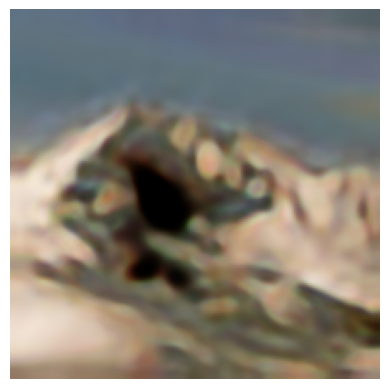

In [7]:
# Convert to PIL image for visualization
to_pil = T.ToPILImage()
generated_image = to_pil(output.squeeze(0))  # Remove batch dimension

# Display the generated image
plt.imshow(generated_image)
plt.axis("off")
plt.show()